In [7]:
import xarray as xr

# Load the predictions
ds_pred = xr.open_dataset('drought-forecasting/modeling-pipeline/data/07_model_output/predictions.nc')

In [8]:
ds_pred

<xarray.Dataset> Size: 330MB
Dimensions:        (forecast_time: 106, horizon: 6, latitude: 180,
                    longitude: 360)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 848B 2014-09-01 ... 2023-06-01
  * horizon        (horizon) int64 48B 1 2 3 4 5 6
  * latitude       (latitude) int64 1kB -90 -89 -88 -87 -86 ... 85 86 87 88 89
  * longitude      (longitude) int64 3kB 0 1 2 3 4 5 ... 354 355 356 357 358 359
Data variables:
    y              (forecast_time, horizon, latitude, longitude) float32 165MB ...
    y_hat          (forecast_time, horizon, latitude, longitude) float32 165MB ...

In [47]:
def plot_full_horizon(
    ds: xr.Dataset,
    forecast_time: Optional[str] = None,
    y_hat: str = "y_hat",
    y: str = "y",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    colormap: str = "custom"
) -> Any:
    """
    Visualize y_hat and y_true for all horizon steps for a specific forecast_time
    using a selectable color scale. The maps are projected with PlateCarree and
    country boundaries/coastlines are added via Cartopy.

    Args:
        ds (xarray.Dataset):
            The dataset containing the specified 'y' and 'y_hat' variables with dimensions:
            (forecast_time, horizon, latitude, longitude).
        forecast_time (str, optional):
            Date (in 'YYYY-MM-DD' format) of the forecast_time coordinate to visualize.
            Defaults to None, which selects the first forecast_time.
        y_hat (str, optional):
            Name of the variable representing model predictions. Defaults to "y_hat".
        y (str, optional):
            Name of the variable representing ground truth. Defaults to "y".
        vmin (float, optional):
            Minimum value for color scaling.
            If None, it is inferred from the data. Defaults to None.
        vmax (float, optional):
            Maximum value for color scaling.
            If None, it is inferred from the data. Defaults to None.
        colormap (str, optional):
            Colormap for visualization.
            - If "custom", uses a custom boundary-based colormap
              (red → orange → green → lightblue → blue).
            - Otherwise, uses a built-in Matplotlib colormap
              (e.g. "RdBu", "viridis", "coolwarm").
            Defaults to "custom".

    Returns:
        Any:
            The resulting figure with subplots showing y_hat and y_true for each horizon step.

    Raises:
        ValueError:
            If the dataset does not contain the specified 'y' or 'y_hat' variables.
        ValueError:
            If the provided forecast_time is not found in the dataset.
    """
    # --- Validate dataset ---
    if not {y, y_hat}.issubset(ds.variables):
        raise ValueError(f"The dataset must contain '{y}' and '{y_hat}' variables.")

    # --- Validate and get the forecast_time index ---
    if forecast_time is not None:
        try:
            forecast_time_idx = np.where(ds.forecast_time == np.datetime64(forecast_time))[0][0]
        except IndexError:
            raise ValueError(f"The provided forecast_time '{forecast_time}' is not found in the dataset.")
    else:
        forecast_time_idx = 0  # Default to the first forecast_time

    # --- Select colormap and normalization approach ---
    if colormap == "custom":
        custom_boundaries = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        custom_colors = ["red", "orange", "green", "green", "lightblue", "blue"]
        cmap = ListedColormap(custom_colors)
        norm = BoundaryNorm(custom_boundaries, cmap.N)
        boundaries = custom_boundaries
    else:
        cmap = plt.get_cmap(colormap)
        norm = None
        boundaries = None

    # --- Extract data for the given forecast_time ---
    y_hat_all_steps = ds[y_hat].isel(forecast_time=forecast_time_idx).values
    y_true_all_steps = ds[y].isel(forecast_time=forecast_time_idx).values

    # --- Coordinates ---
    lats = ds.latitude.values
    lons = ds.longitude.values
    forecast_time_val = pd.to_datetime(ds.forecast_time.values[forecast_time_idx])

    # Calculate the start date (11 months before forecast_time_val)
    start_date = forecast_time_val - pd.DateOffset(months=11)

    # Format the dates
    start_str = start_date.strftime("%Y-%m")
    end_str = forecast_time_val.strftime("%Y-%m")

    # Define the actual forecast dates based on horizon
    horizon_steps = ds.horizon.values
    forecast_dates = [
        forecast_time_val + pd.DateOffset(months=int(step)) for step in horizon_steps
    ]

    # Shift longitude from [0, 360] to [-180, 180] if necessary
    lons_shifted = np.where(lons > 180, lons - 360, lons)

    # Sort the longitudes and corresponding data
    sorted_indices = np.argsort(lons_shifted)
    lons_sorted = lons_shifted[sorted_indices]

    # Compute vmin/vmax if not provided
    if vmin is None:
        vmin = min(np.nanmin(y_hat_all_steps), np.nanmin(y_true_all_steps))
    if vmax is None:
        vmax = max(np.nanmax(y_hat_all_steps), np.nanmax(y_true_all_steps))

    # --- Use Cartopy for plotting with country boundaries ---
    projection = ccrs.PlateCarree(central_longitude=0)
    fig, axes = plt.subplots(
        nrows=len(horizon_steps),
        ncols=2,
        subplot_kw={"projection": projection},
        figsize=(14, 4 * len(horizon_steps)),
        constrained_layout=True
    )
    fig.suptitle(
        f"Total precipitation in millimeters\n1 mm = 10 liters of water per square meter\nForecasting based on {start_str} to {end_str}",
        fontsize=16,
        fontweight="bold"
    )

    # --- Plot each horizon step ---
    for step in range(len(horizon_steps)):
        # Extract data for the current horizon step
        y_hat_map = y_hat_all_steps[step]
        y_true_map = y_true_all_steps[step]
        forecast_date_str = forecast_dates[step].strftime("%Y-%m")

        # Determine axes for single or multiple horizon steps
        if len(horizon_steps) == 1:
            ax_hat, ax_true = axes
        else:
            ax_hat = axes[step, 0]
            ax_true = axes[step, 1]

        # Add country boundaries and coastlines
        for ax in (ax_hat, ax_true):
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            # Optionally add gridlines with labels
            gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
            gl.right_labels = False
            gl.top_labels = False

        # --- Plot y_hat ---
        mesh_hat = ax_hat.pcolormesh(
            lons_sorted,
            lats,
            y_hat_map[:, sorted_indices],
            cmap=cmap,
            norm=norm,
            vmin=vmin,
            vmax=vmax,
            shading="auto",
            transform=ccrs.PlateCarree()
        )
        ax_hat.set_title(f"{y_hat} - {forecast_date_str}", fontsize=14)

        # Add colorbar for y_hat on the first row
        if step == 0:
            if boundaries is not None:
                cbar_hat = plt.colorbar(
                    mesh_hat,
                    ax=ax_hat,
                    orientation="horizontal",
                    fraction=0.046,
                    pad=0.04,
                    boundaries=boundaries
                )
                cbar_hat.set_label(f"{y_hat} value in mm", fontsize=12)
                cbar_hat.set_ticks(boundaries)
                cbar_hat.set_ticklabels([f"{b:.1f}" for b in boundaries])
            else:
                cbar_hat = plt.colorbar(
                    mesh_hat,
                    ax=ax_hat,
                    orientation="horizontal",
                    fraction=0.046,
                    pad=0.04
                )
                cbar_hat.set_label(f"{y_hat} value in mm", fontsize=12)

        # --- Plot y_true ---
        mesh_true = ax_true.pcolormesh(
            lons_sorted,
            lats,
            y_true_map[:, sorted_indices],
            cmap=cmap,
            norm=norm,
            vmin=vmin,
            vmax=vmax,
            shading="auto",
            transform=ccrs.PlateCarree()
        )
        ax_true.set_title(f"{y} - {forecast_date_str}", fontsize=14)

        # Add colorbar for y_true on the first row
        if step == 0:
            if boundaries is not None:
                cbar_true = plt.colorbar(
                    mesh_true,
                    ax=ax_true,
                    orientation="horizontal",
                    fraction=0.046,
                    pad=0.04,
                    boundaries=boundaries
                )
                cbar_true.set_label(f"{y} value", fontsize=12)
                cbar_true.set_ticks(boundaries)
                cbar_true.set_ticklabels([f"{b:.1f}" for b in boundaries])
            else:
                cbar_true = plt.colorbar(
                    mesh_true,
                    ax=ax_true,
                    orientation="horizontal",
                    fraction=0.046,
                    pad=0.04
                )
                cbar_true.set_label(f"{y} value", fontsize=12)

    plt.show()
    # return fig


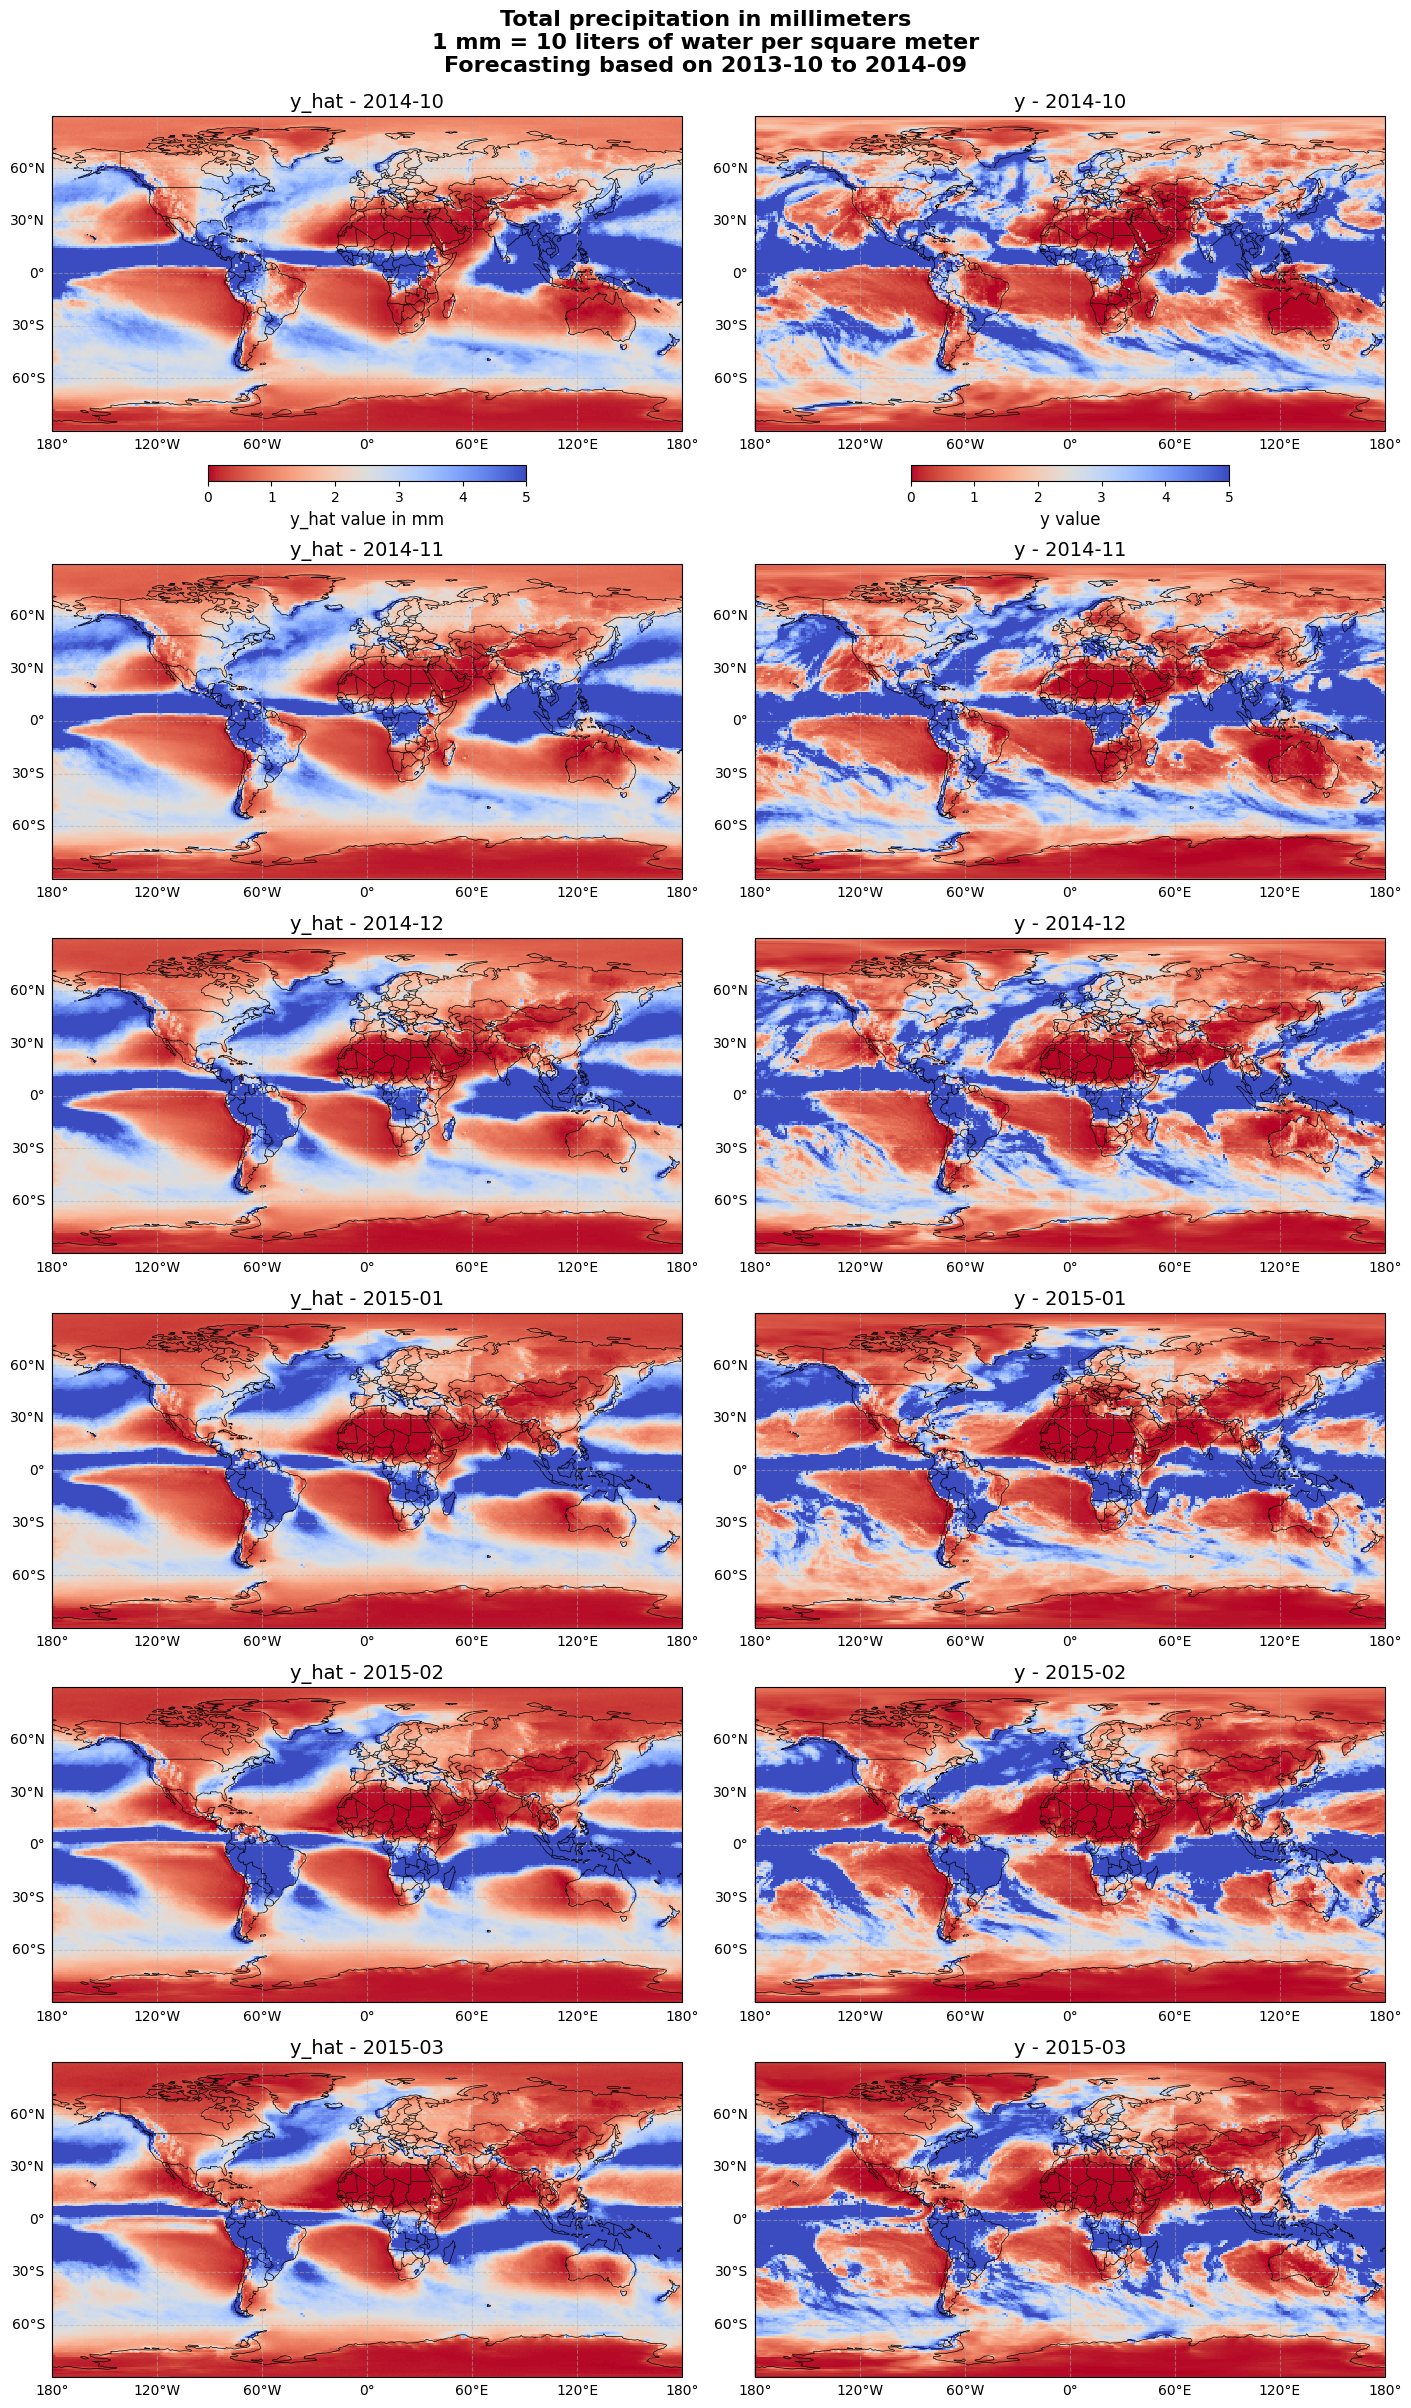

In [48]:
plot_full_horizon(
    ds_pred,
    forecast_time="2014-09-01",  # Specify the desired forecast_time
    y_hat="y_hat",
    y="y",
    vmin=0,
    vmax=5,
    colormap="coolwarm_r"
)


In [36]:
import xarray as xr
import os
import glob

# Define the preprocess function
def preprocess(file_path):
    """
    Preprocess a single dataset:
    - Load the dataset.
    - Extract the crop name from the file path.
    - Keep only the 'croparea' variable.
    - Rename 'croparea' to include the crop name.
    - Remove attributes to avoid conflicts.

    Args:
        file_path (str): Path to the NetCDF file.

    Returns:
        xarray.Dataset: Preprocessed dataset.
    """
    # Load the dataset
    ds = xr.open_dataset(file_path, chunks="auto")
    
    # Extract crop name from filename
    file_name = os.path.basename(file_path)
    crop_name = file_name.split("_")[-1].split(".")[0]  # Extracts 'carrot'

    # Keep only 'croparea' and rename it
    ds = ds[['croparea']].rename_vars({'croparea': f'{crop_name}_croparea'})

    # Remove conflicting attributes
    ds.attrs = {}
    return ds

# Define the directory containing your NetCDF files
data_dir = '/teamspace/studios/this_studio/drought-forecasting/modeling-pipeline/data/01_raw/unzipped_files/CROPGRIDS/CROPGRIDSv1.08_NC_maps/CROPGRIDSv1.08_NC_maps/'

# Create a sorted list of file paths
file_list = sorted(glob.glob(data_dir + '*.nc'))

# Exclude specific file
excluded_file = 'Countries_2018.nc'
file_list = [file for file in file_list if not file.endswith(excluded_file)]

# Preprocess each file and combine them
datasets = [preprocess(file_path) for file_path in file_list]
crop_ds = xr.combine_by_coords(datasets, combine_attrs="override")

In [37]:
# Apply mask: Set values below 100 to 0, and values equal to or above 100 to 1
crop_ds = crop_ds.map(lambda da: xr.where(da >= 1, 1, 0))

# Step 1: Adjust longitude for crop_ds
crop_ds = crop_ds.assign_coords(lon=((crop_ds.lon + 360) % 360)).sortby('lon')

In [38]:
import xarray as xr

def mask_with_crop_area(ds: xr.Dataset, crop_ds: xr.Dataset, variable: str, crop: str) -> xr.Dataset:
    """
    Interpolates `crop_ds` to match `ds` using Dask, then masks a variable in `ds` with a crop area from `crop_ds`.
    Creates a new variable in `ds` with the masked values.

    Args:
        ds (xr.Dataset): Dataset containing the variable to mask.
        crop_ds (xr.Dataset): Dataset containing crop area variables.
        variable (str): Name of the variable in `ds` to mask.
        crop (str): Specific crop variable to use for masking (e.g., 'cotton_croparea').

    Returns:
        xr.Dataset: Dataset with a new variable containing the masked values.

    Raises:
        ValueError: If the specified variable or crop is not found in the datasets.
    """
    if variable not in ds:
        raise ValueError(f"Variable '{variable}' not found in the dataset `ds`.")

    # Unify chunks for consistent Dask operations
    ds = ds.unify_chunks()
    crop_ds = crop_ds.unify_chunks()

    # Check if the specific crop is in the crop dataset
    if crop not in crop_ds:
        raise ValueError(f"Crop variable '{crop}' not found in the dataset `crop_ds`.")

    # Use the specific crop area as the mask
    mask = crop_ds[crop]

    # Interpolate crop mask to match `ds` spatial resolution using Dask
    interpolated_mask = mask.interp(
        lat=ds.latitude, lon=ds.longitude, method="nearest"
    )

    # Mask the variable
    masked_variable = ds[variable].where(interpolated_mask > 0)

    # Add the masked variable as a new variable in the dataset
    masked_variable_name = f"{variable}_{crop}"
    ds[masked_variable_name] = masked_variable

    return ds


In [44]:
ds = mask_with_crop_area(ds_pred, crop_ds, "y", crop="barley_croparea")
ds = mask_with_crop_area(ds_pred, crop_ds, "y_hat", crop="barley_croparea")

In [45]:
ds

<xarray.Dataset> Size: 659MB
Dimensions:                (forecast_time: 106, horizon: 6, latitude: 180,
                            longitude: 360)
Coordinates:
  * forecast_time          (forecast_time) datetime64[ns] 848B 2014-09-01 ......
  * horizon                (horizon) int64 48B 1 2 3 4 5 6
  * latitude               (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude              (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    lat                    (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
    lon                    (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
Data variables:
    y                      (forecast_time, horizon, latitude, longitude) float32 165MB ...
    y_hat                  (forecast_time, horizon, latitude, longitude) float32 165MB ...
    y_barley_croparea      (forecast_time, horizon, latitude, longitude) float32 165MB dask.array<chunksize=(106, 6, 180, 360), meta=np.ndarray>
    y_hat_barley_croparea  (forecast_time, horizon, latitude, longitude) float32 165MB dask.array<chunksize=(106, 6, 180, 360), meta=np.ndarray>

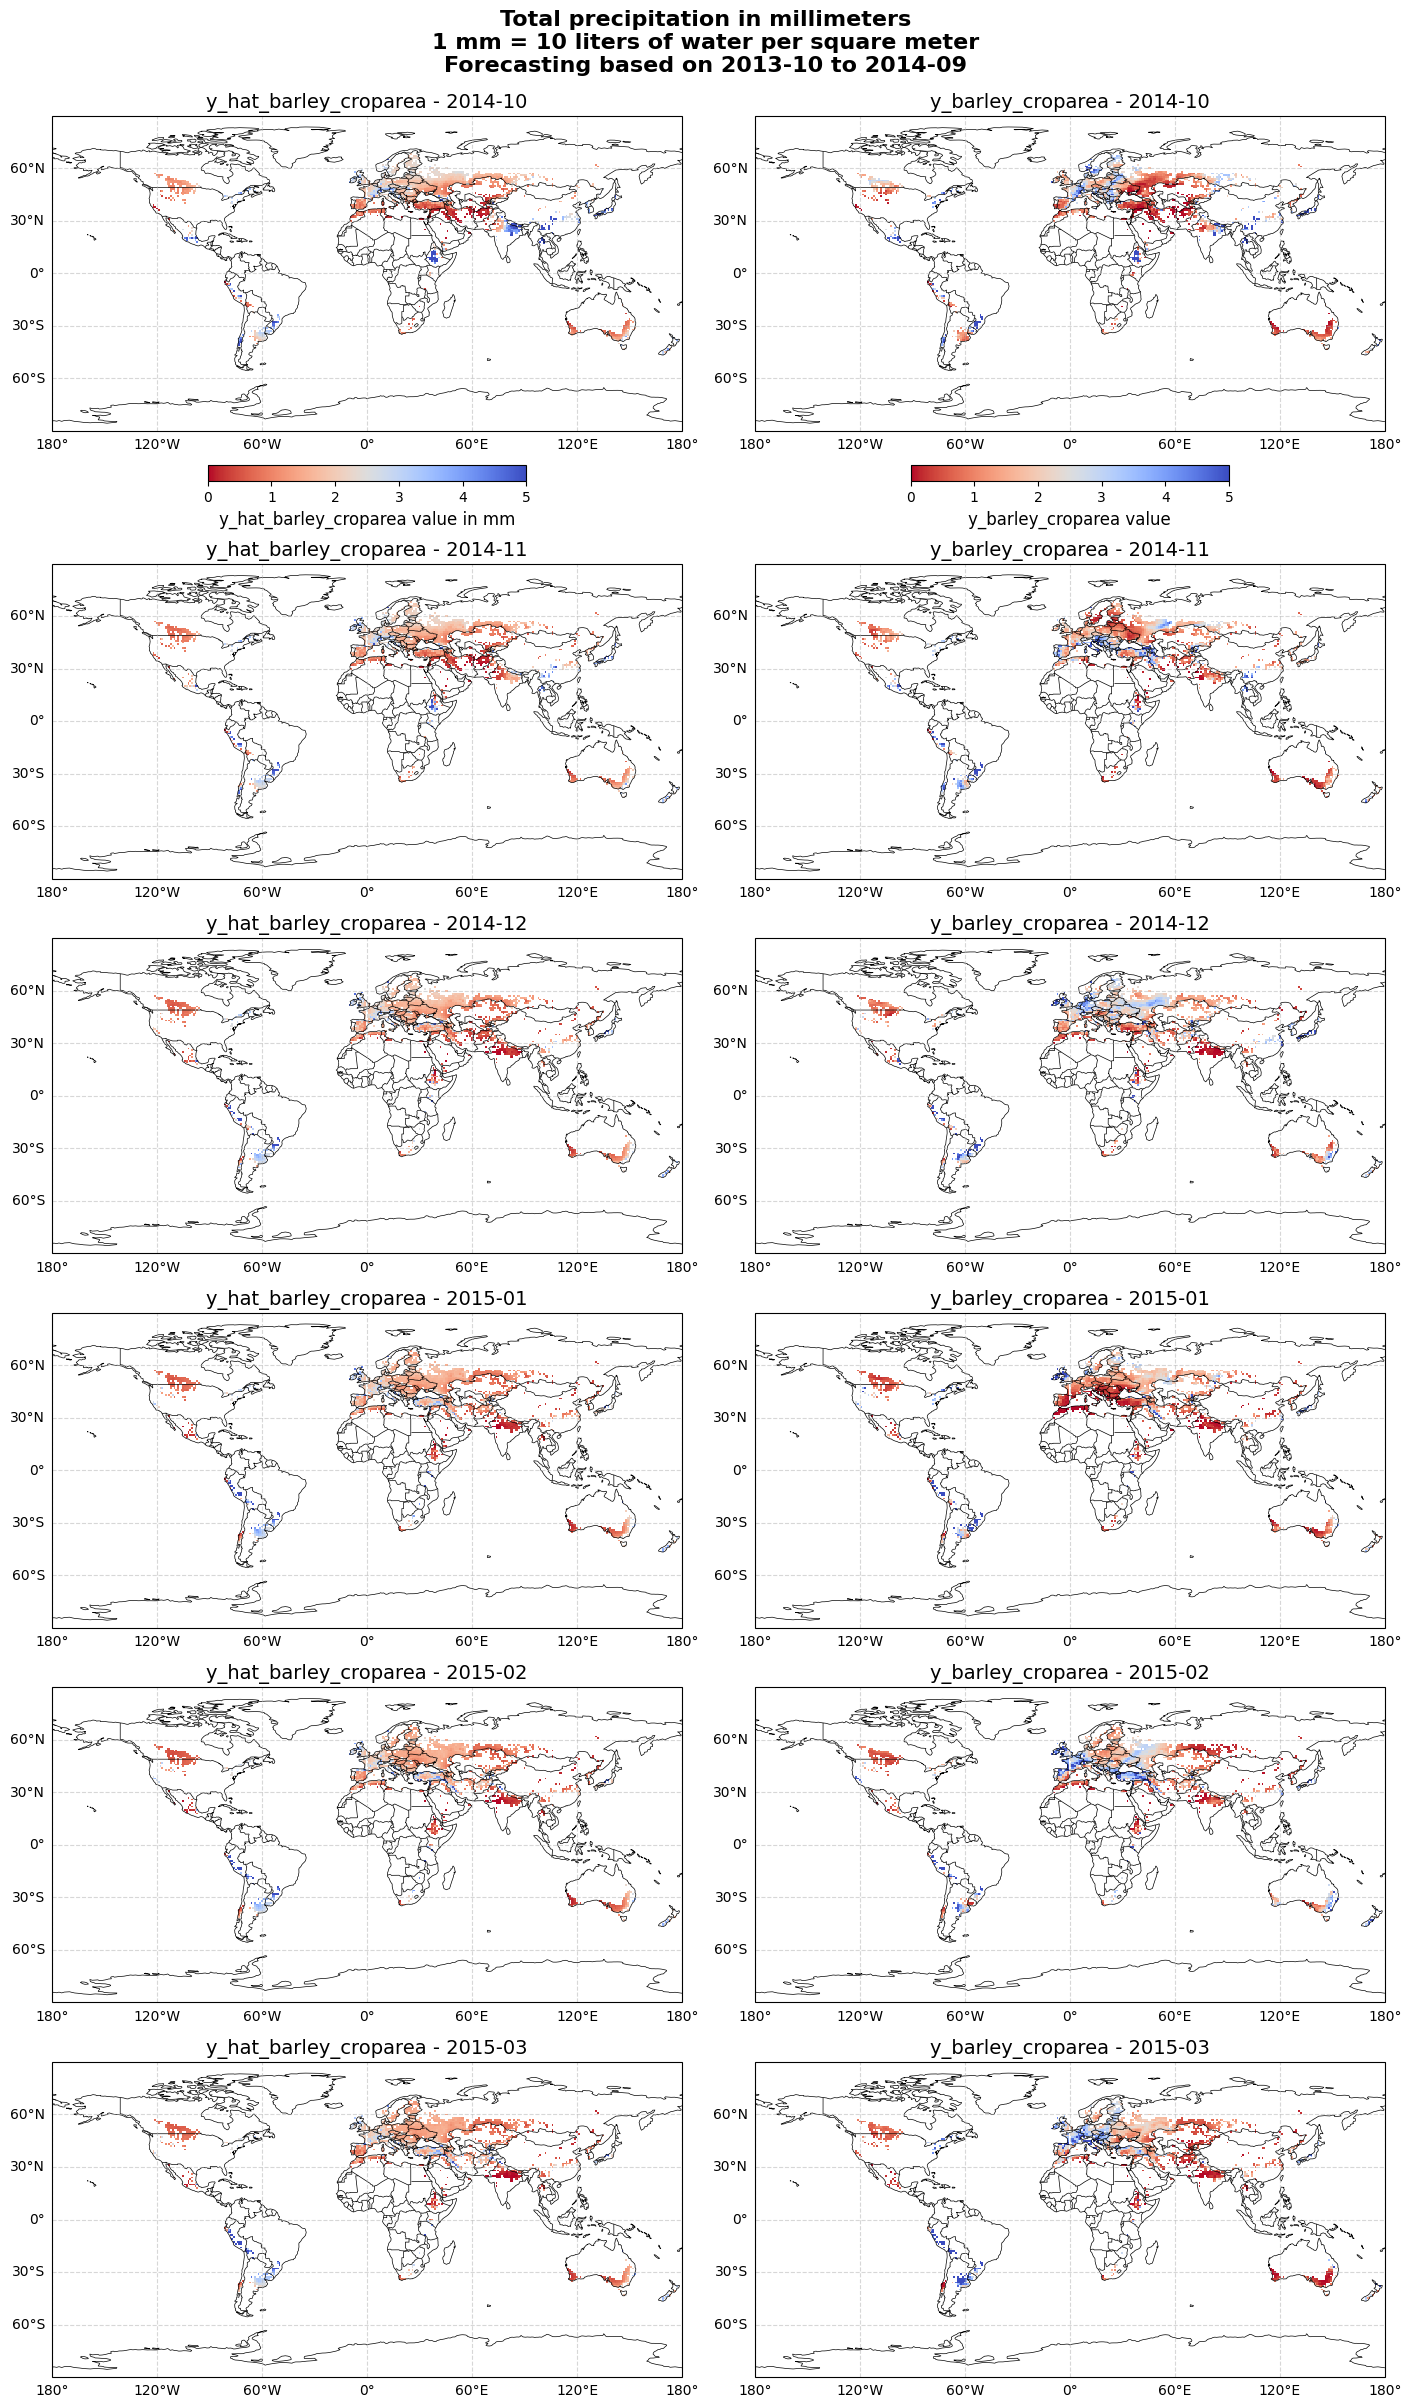

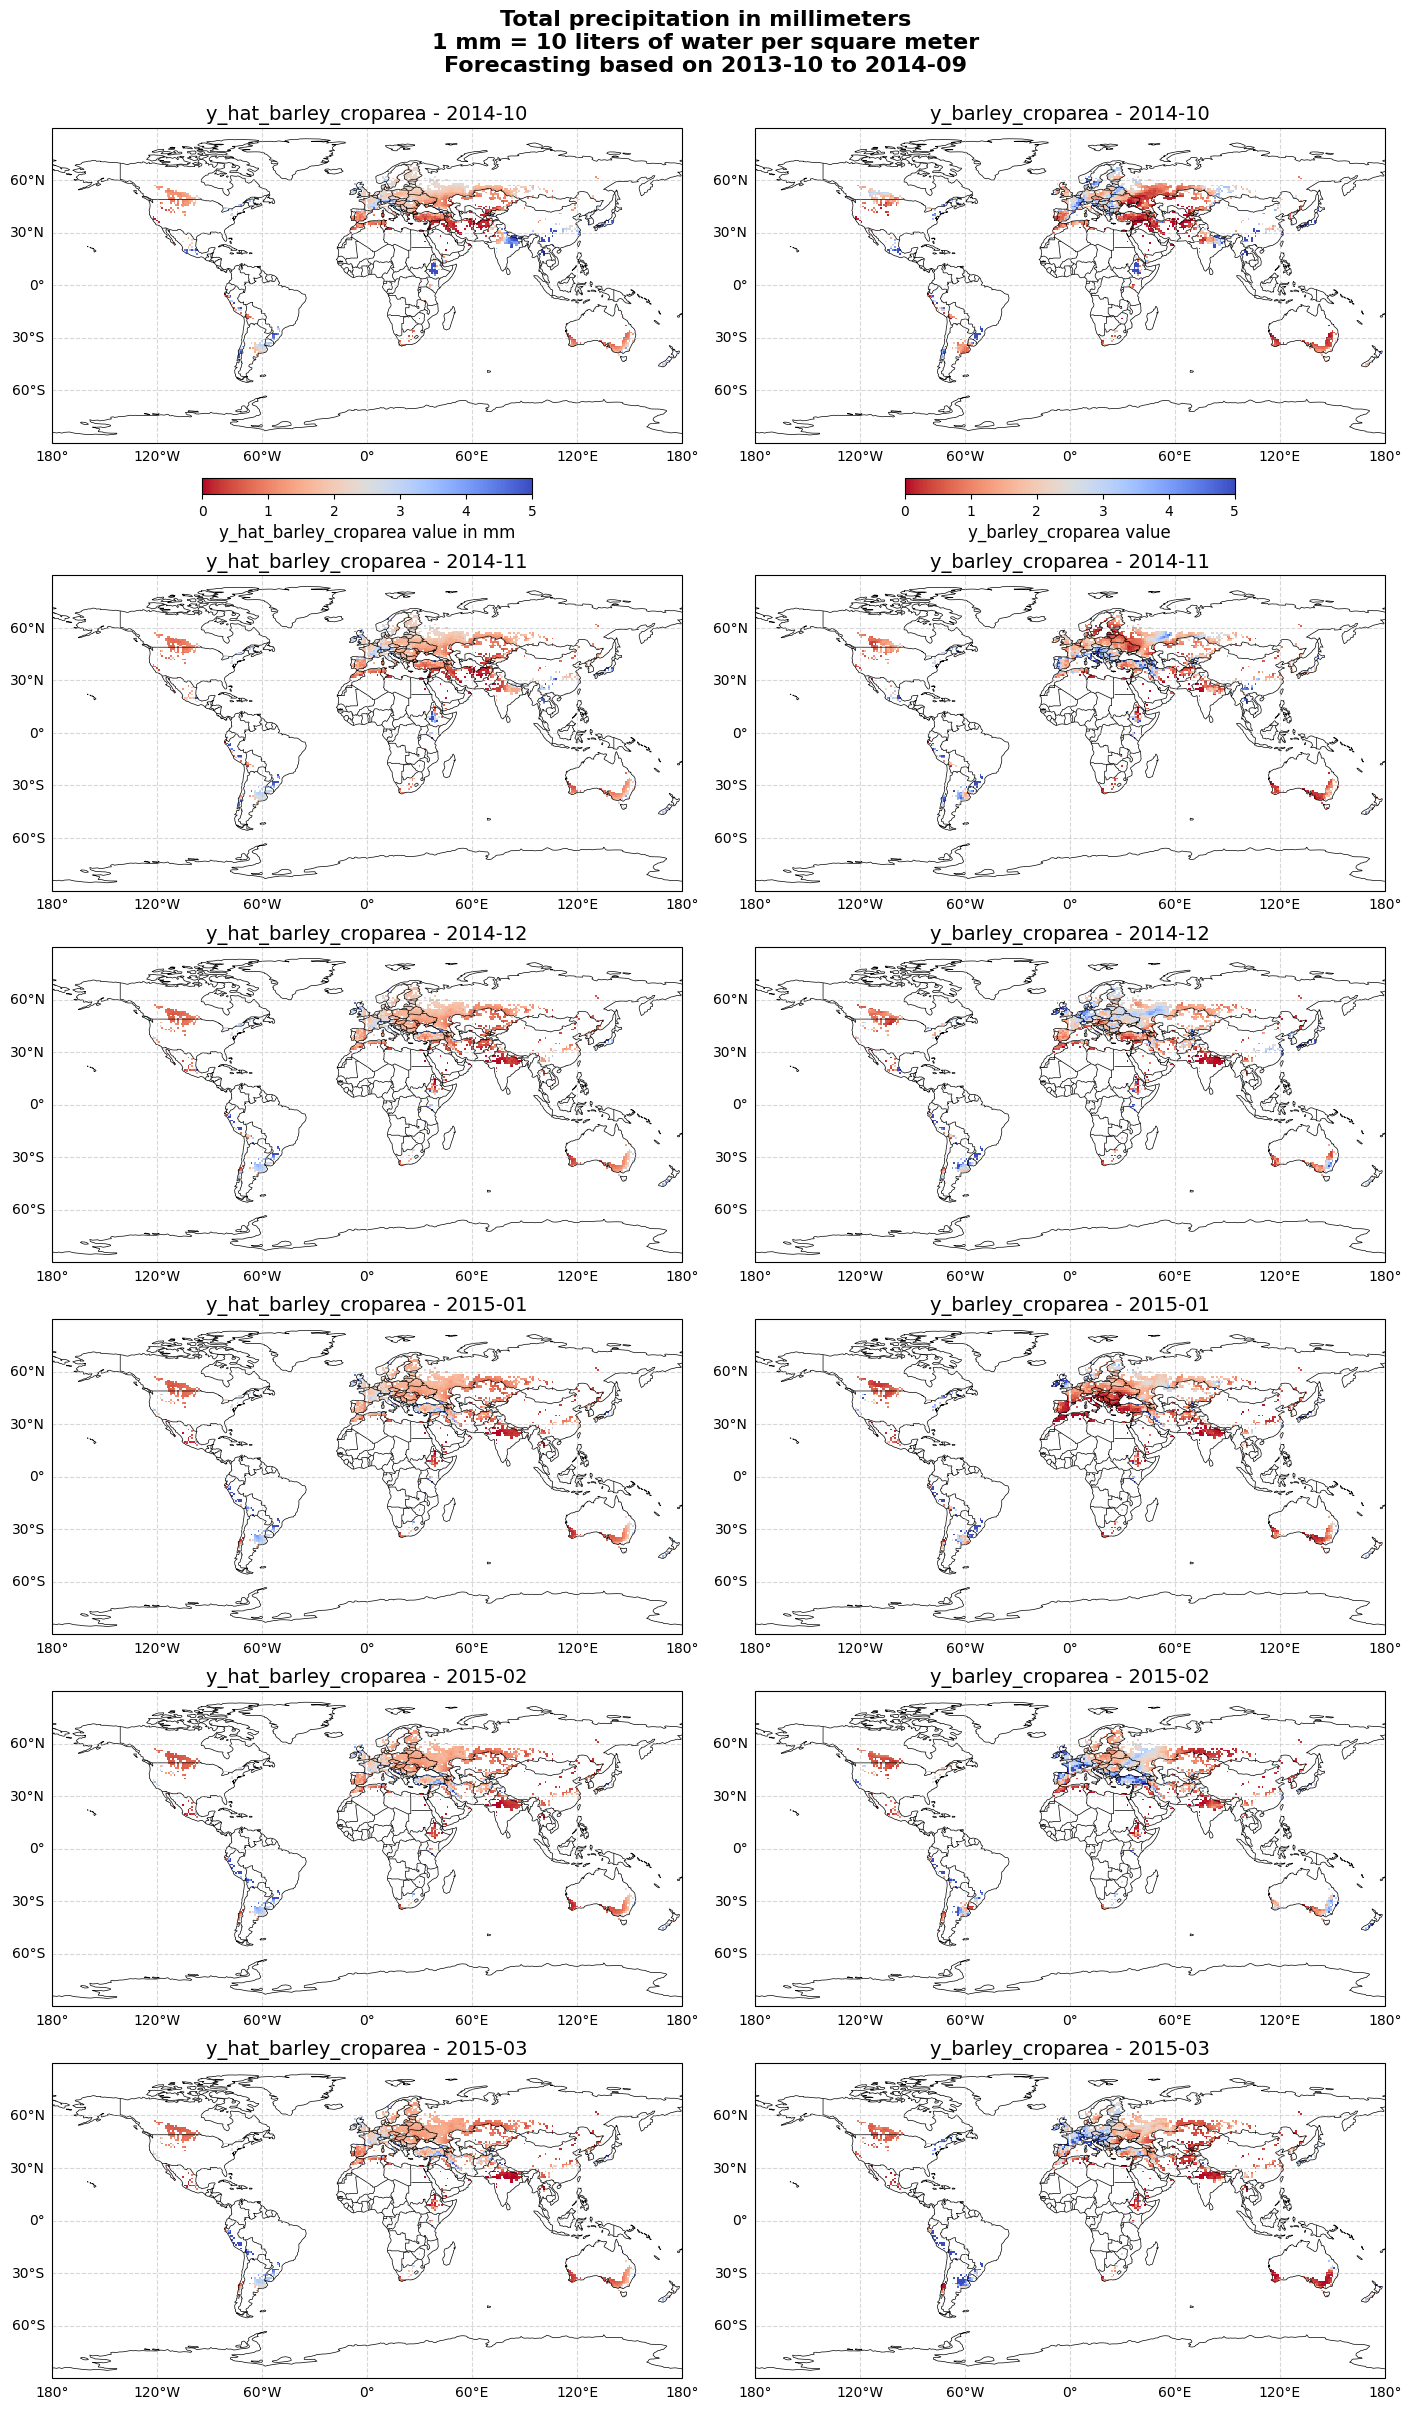

In [46]:
plot_full_horizon(
    ds,
    forecast_time="2014-09-01",  # Specify the desired forecast_time
    y_hat="y_hat_barley_croparea",
    y="y_barley_croparea",
    vmin=0,
    vmax=5,
    colormap="coolwarm_r"
)
